#[문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std 값 찾기

In [1]:
import os
from pathlib import Path
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import transforms

BASE_PATH = "/content"

data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

# FashionMNIST 데이터셋을 train=True로 설정하여 학습 데이터셋을 로드
f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

imgs = torch.stack([img_t for img_t, _ in f_mnist_train], dim=3)
print(imgs.shape)
mean = imgs.view(1, -1).mean(dim=-1)
std = imgs.view(1, -1).std(dim=-1)

print('Mean:', mean)
print('Std:', std)

f_mnist_transforms = nn.Sequential(
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize(mean=mean, std=std),
)


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]


Extracting /content/_00_data/j_fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/_00_data/j_fashion_mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting /content/_00_data/j_fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/_00_data/j_fashion_mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting /content/_00_data/j_fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/_00_data/j_fashion_mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.13MB/s]


Extracting /content/_00_data/j_fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/_00_data/j_fashion_mnist/FashionMNIST/raw

torch.Size([1, 28, 28, 60000])
Mean: tensor([0.2860])
Std: tensor([0.3530])


[문제 1]의 답: Mean: 0.2860 / Std: 0.3530

#[문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

In [14]:
!pip install torchinfo

In [17]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from datetime import datetime
import os
import wandb
from pathlib import Path
from torchinfo import summary


BASE_PATH = str(".")
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("."))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from utils import is_linux, is_windows, get_num_cpu_cores
from c_trainer import ClassificationTrainer
from e_arg_parser import get_parser

#residual block 설정
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.LazyBatchNorm2d()
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size=1, stride=stride),
        nn.LazyBatchNorm2d()
      )

  def forward(self, x):
    out = nn.ReLU()(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    return nn.ReLU()(out)

# ResNet 기반 CNN 모델
def get_resnet_cnn_model():
  class MyModelWithResNet(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()
      self.model = nn.Sequential(
        ResidualBlock(in_channels, 32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        ResidualBlock(32, 64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        ResidualBlock(64, 128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.LazyLinear(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.LazyLinear(n_output),
        )

    def forward(self, x):
      return self.model(x)

  # 1 * 28 * 28
  my_model_resnet = MyModelWithResNet(in_channels=1, n_output=10)

  return my_model_resnet

# Fashion MNIST 데이터를 로드하고 전처리
def get_fashion_mnist_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  # Fashion MNIST 데이터를 다운로드하고 전처리
  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  # 학습 데이터와 검증 데이터로 분리
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))

  # colab에서는 최대 2까지만 지원한다는 경고가 출력되기 때문에 utils의 get_num_cpu_cores를 쓰지 않았다.
  num_data_loading_workers = 2


  # 데이터 로더를 생성
  train_data_loader = DataLoader(
    dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  validation_data_loader = DataLoader(
    dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  # 데이터를 정규화하는 변환 함수를 정의
  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.3530),
  )

  return train_data_loader, validation_data_loader, f_mnist_transforms


def main(args):
  parser = get_parser()
  args = parser.parse_args()
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs if args.epochs else 10000,
    'batch_size': args.batch_size if args.batch_size else 512,
    'validation_intervals': args.validation_intervals if args.validation_intervals else 10,
    'learning_rate': args.learning_rate if args.learning_rate else 1e-3,
    'early_stop_patience': args.early_stop_patience if args.early_stop_patience else 10,
    'early_stop_delta': args.early_stop_delta if args.early_stop_delta else 0.00001

  }

  # wandb를 사용
  project_name = "cnn_mnist"
  wandb.init(
    mode="online",
    project=project_name,
    notes="fashion mnist experiment with cnn",
    tags=["cnn", "fashion_mnist"],
    name="resnet/"+run_time_str,
    config=config,
    settings=wandb.Settings(start_method="fork", resume="never")
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
  model = get_resnet_cnn_model()
  model.to(device)


  # LazyModules 초기화를 위해 더미 입력을 한 번 전달
  dummy_input = torch.randn(1, 1, 28, 28, device=device)  # 배치 크기 1, 채널 1, 28x28 이미지
  model(dummy_input)

  print(summary(model, input_size=(128, 1, 28, 28)))

  wandb.watch(model)

  # 모델의 파라미터를 최적화하는 옵티마이저와 학습률 스케줄러를 설정
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, betas=(0.9, 0.999), weight_decay=0.0005)

  # ClassificationTrainer 인스턴스를 생성하고, 학습 루프를 시작
  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )

  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  import sys
  wandb.login()
  sys.argv = sys.argv[:1]  # Colab에서 추가된 불필요한 인자 제거
  # 파이썬 코드가 직접 실행될 때만 main 함수를 호출하여 학습을 시작
  parser = get_parser()
  args, unknown = parser.parse_known_args()
  main(args)


Namespace(wandb=False, batch_size=128, epochs=1000, learning_rate=0.001, validation_intervals=1, early_stop_patience=5, early_stop_delta=1e-05)
{'epochs': 1000, 'batch_size': 128, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 1e-05}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Layer (type:depth-idx)                   Output Shape              Param #
MyModelWithResNet                        [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─ResidualBlock: 2-1                [128, 32, 28, 28]         --
│    │    └─Conv2d: 3-1                  [128, 32, 28, 28]         320
│    │    └─BatchNorm2d: 3-2             [128, 32, 28, 28]         64
│    │    └─Conv2d: 3-3                  [128, 32, 28, 28]         9,248
│    │    └─BatchNorm2d: 3-4             [128, 32, 28, 28]         64
│    │    └─Sequential: 3-5              [128, 32, 28, 28]      

Epoch,▁▂▂▃▄▅▅▆▇▇█
Training accuracy (%),▁▄▅▆▇▇█████
Training loss,█▅▄▂▂▂▁▁▁▁▁
Training speed (epochs/sec.),▁▄▆▆▇▇▇████
Validation accuracy (%),▂▁▃▇▇███▇██
Validation loss,▇█▆▁▁▁▁▁▁▁▁
Epoch,11
Training accuracy (%),97.00182
Training loss,0.08646
Training speed (epochs/sec.),0.08943
Validation accuracy (%),94.26


위와 같이 Validation accuracy가 94.26%이므로 문제의 조건에 부합한다.

그리고 교수님께서 말씀하신대로 torchinfo 모듈을 사용하여 모델 구조를 출력하였다.

- batch size: 2048, 1024, 512, 256, 128, 64 중에 128과 64에서 좋은 성능을 보였다. resnet으로 수정하면서 128일 때 가장 좋은 성능을 보여서 128로 설정하였다.
- lr_scheduler: lr_scheduler를 사용하는 것의 validation accuracy가 더 좋게 나와서 c_trainer.py 코드 안에 스케줄러를 사용하도록 만들어주었다. 작성한 코드는 아래와 같다. 한 epoch에서 많은 연산이 이뤄지기 때문에 경험적인 판단으로 step _size를 적당히 3 정도로 주었다.
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.1)

- validation_interval: early stop을 좀 더 효율적으로 하기 위해 1로 설정하였다.
- early stop patience: 한 epoch에서 많은 연산이 일어나기 때문에 5로 설정하였다.
- batch nomalization: 저번 과제에서 사용했던 batch nomalization도 사용했다. 안정적인 학습이 가능하고, 정규화 효과를 통해 과적합을 방지할 수 있다.
- dropout: dropout이 없을 때부터 0.5까지 진행해보았고, 보통 0.5가 적절하다고 알고 있었는데, 이번에는 0.2~0.3 정도에서 가장 좋은 성능을 보였다. resnet으로 수정하면서 0.3으로 고정하였다.
- 활성화 함수: leakyReLU, ELU, ReLU를 사용해보았고, ReLU의 성능이 유의미하게 좋았기 때문에 ReLU를 사용하였다.
- learning rate: 0.01, 0.001, 0.0001을 사용해본 결과 0.001이 월등히 좋은 성능을 보였다.
- optimizer: 기존에 썼던 SGD 등 다른 optimizer보다 adam의 성능이 제일 좋아서 adam을 사용하였다.
- weight decay: 0.01, 0.001, 0.0001, 0.00001, 0.0003, 0.0005 등 다양하게 조절해보았고, 1e-4 정도의 weight decay에서 가장 좋은 성능이 나왔다. 이 정도 수준에서 조금 더 조절해본 결과 0.0005가 가장 좋다고 생각했다.
- image augmentation: 이미지를 랜덤으로 좌우반전하고, -10도에서 10도 범위 내에서 랜덤으로 회전시키도록 하여 학습 성능을 높이도록 하고 싶었지만, 실제 학습 결과 validation_accuracy 값이 거의 1프로나 떨어지게 나와서 원래 코드로 돌아왔다. image augmentation을 위해 작성한 코드를 아래에 첨부하였다.
      f_mnist_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530)  # Fashion MNIST의 평균과 표준편차
      ])

#[문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: checkpoints/cnn_mnist_checkpoint_latest.pt
TEST RESULTS: 93.200%

     LABEL: 9


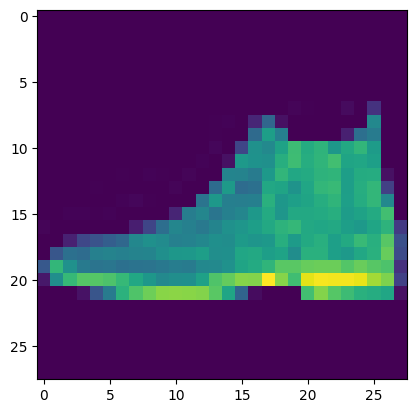

PREDICTION: 9


In [30]:
import numpy as np
import torch
import os

from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from pathlib import Path

from torch.utils.data import DataLoader

BASE_PATH = str(".")
CURRENT_FILE_PATH = os.path.dirname(".")
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

import sys
sys.path.append(BASE_PATH)

from hw3 import get_resnet_cnn_model
from a_fashion_mnist_data import get_fashion_mnist_test_data
from d_tester import ClassificationTester


def get_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  fashion_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)

  fashion_mnist_test = datasets.FashionMNIST(
        data_path, train=False, download=True, transform=transforms.ToTensor()
    )
  test_data_loader = DataLoader(dataset=fashion_mnist_test, batch_size=len(fashion_mnist_test))

  mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.3530),
  )

  return fashion_mnist_test_images, test_data_loader, mnist_transforms


def main():
  fashion_mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

  test_model = get_resnet_cnn_model()

  project_name = "cnn_mnist"
  classification_tester = ClassificationTester(
    project_name, test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
  )
  classification_tester.test()

  print()

  img, label = fashion_mnist_test_images[0]
  print("     LABEL:", label)
  plt.imshow(img)
  plt.show()

  # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
  output = classification_tester.test_single(
    torch.tensor(np.array(fashion_mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0)
  )
  print("PREDICTION:", output)


if __name__ == "__main__":
  main()


위와 같이 Test accuracy가 93.2%이므로 문제의 조건에 부합한다.

#[문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

이미지 예측 시작
Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: checkpoints/cnn_mnist_checkpoint_latest.pt
Image 1:
   LABEL: 4


/content/d_tester.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))


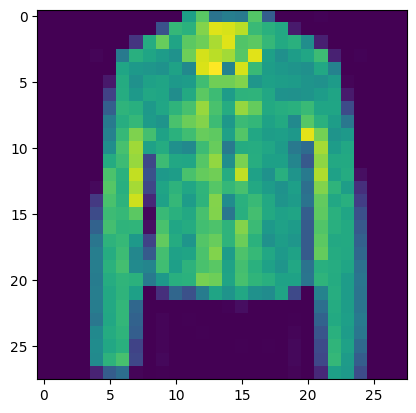

PREDICTION: 4

Image 2:
   LABEL: 5


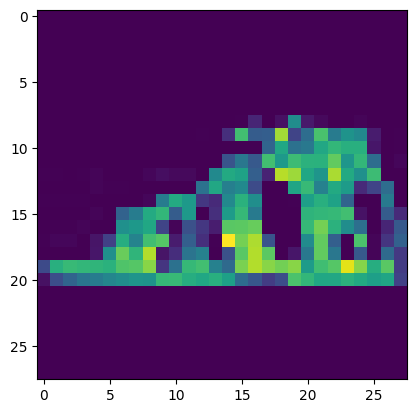

PREDICTION: 5

Image 3:
   LABEL: 7


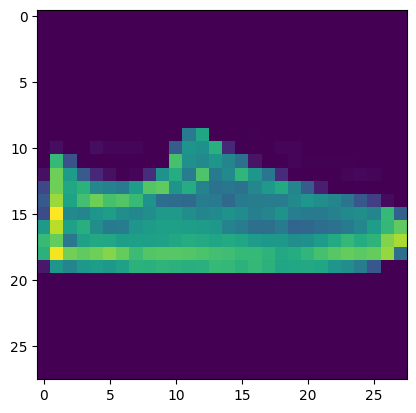

PREDICTION: 5

Image 4:
   LABEL: 3


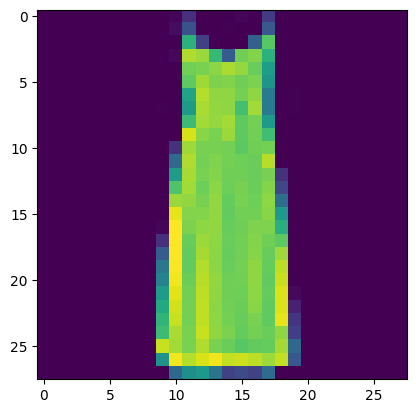

PREDICTION: 3

Image 5:
   LABEL: 4


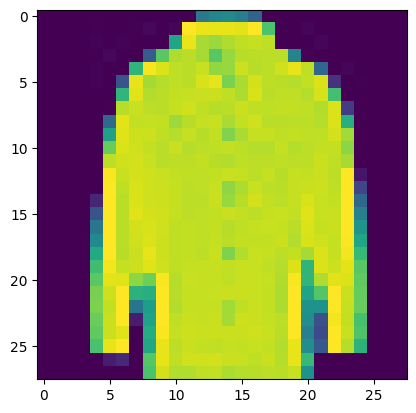

PREDICTION: 4

Image 6:
   LABEL: 1


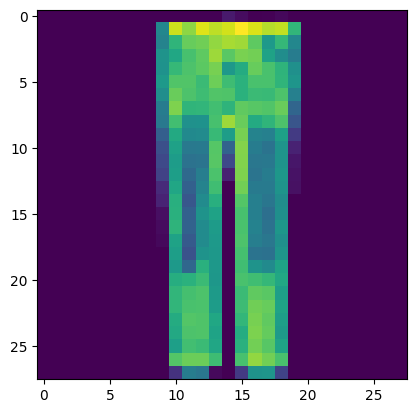

PREDICTION: 1

Image 7:
   LABEL: 2


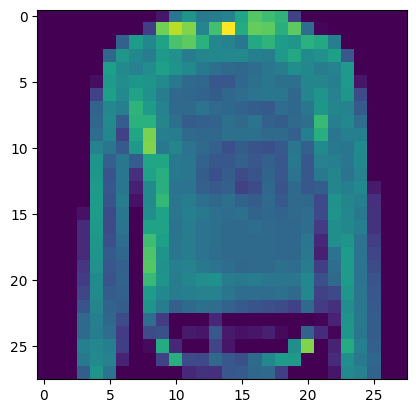

PREDICTION: 2

Image 8:
   LABEL: 4


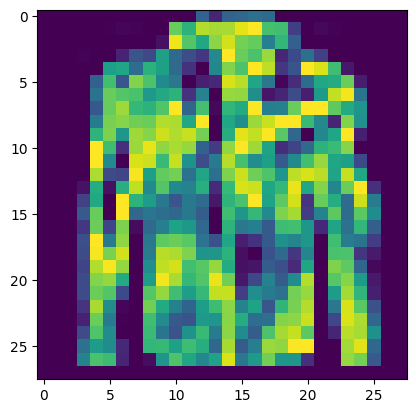

PREDICTION: 6

Image 9:
   LABEL: 8


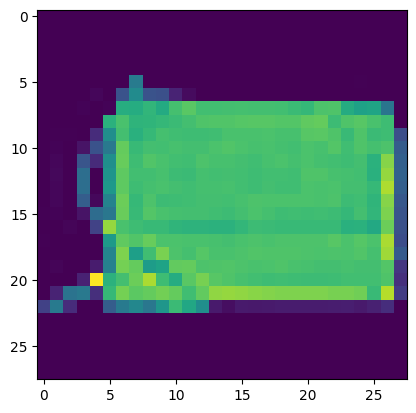

PREDICTION: 8

Image 10:
   LABEL: 0


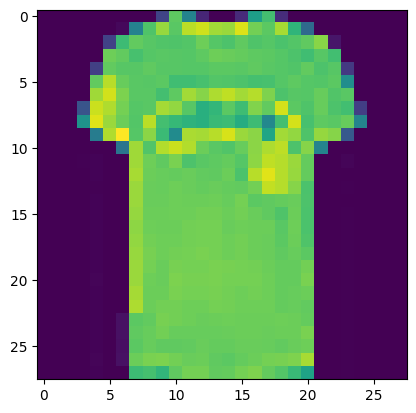

PREDICTION: 0



In [33]:
from hw3 import get_resnet_cnn_model
from a_fashion_mnist_data import get_fashion_mnist_test_data
from d_tester import ClassificationTester

def main():
    print("이미지 예측 시작")
      # 모델과 테스트 데이터를 가져옵니다.
    model = get_resnet_cnn_model()
    project_name = "cnn_mnist"

    # 테스트 데이터 준비
    fashion_mnist_test_images, test_data_loader, fashion_mnist_transforms = get_fashion_mnist_test_data()

    # ClassificationTester를 초기화합니다.
    classification_tester = ClassificationTester(
        project_name, model, test_data_loader, fashion_mnist_transforms, CHECKPOINT_FILE_PATH
    )

    # 임의의 이미지 10장에 대한 분석을 수행합니다.
    for i in range(10):
        img, label = fashion_mnist_test_images[i+10]
        print(f"Image {i + 1}:")
        print("   LABEL:", label)

        # 이미지를 표시합니다.
        plt.imshow(img)
        plt.show()

        # 모델을 사용하여 예측을 수행합니다.
        output = classification_tester.test_single(torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0))
        print("PREDICTION:", output)
        print()


if __name__ == "__main__":
    main()

예측 실행 결과를 아래에 한눈에 보이도록 만들었다. 먼저 각 라벨에 대한 명칭은 아래와 같다.

0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot

괄호 안에는 (Label, Prediction) 순서로 적어두었다.

image1: (4,4), 정답

image2: (5,5), 정답

image3: (7,5), ******오답

image4: (3,3), 정답

image5: (4,4), 정답

image6: (1,1), 정답

image7: (2,2), 정답

image8: (4,6), ******오답

image9: (8,8), 정답

image10: (0,0), 정답

이미지 2개의 예측을 실패한 것으로 나왔다.


image3는 sneaker인데 sandal로 예측하였고, image8는 coat인데 shirt로 예측하였다.

image3을 살펴보면 눈으로 보기에 image3은 sneaker로 보이기는 한다. 모델이 sandal로 예측한 이유를 생각해보면, 바로 위의 sandal 이미지처럼 신발 내부에 검정색으로 비어있는 부분이 있으면 sandal로 예측을 하는 것 같다. 실제로 image3의 sneaker 내부에 약간의 어두운 선같은 부분들이 있는데, 이런 부분들을 통해 그 쪽이 비어있다고 생각하고 이 이미지를 sandal로 예측한 것으로 보인다.

다음으로 image8을 살펴보면, 눈으로 보기에도 image8은 shirt로 보이는데 label은 coat라고 한다. 셔츠의 구김처럼 보이는 이미지와, 가운데 지퍼 또는 단추가 있을 것 같은 비주얼이기 때문에 shirt라고 예측한 것 같다. 이 이미지는 나도 shirt로밖에 안보이기 때문에 이 모델이 이 이미지를 shirt로 예측한 것은 제대로 예측한 것이라 생각한다. 굳이 생각해보면 옷 윗부분이 뭔가 coat의 털 같이 보이기도 하지만, 개인적으로 왜 coat인지는 잘 모르겠다.

#숙제 후기

- 처음에는 2conv 2linear로 시작했고, validation accuracy는 90%도 간당간당한 수준이었다. 그래서 내가 이 과제를 94%까지 끌어올릴 수 있을지 막막하고 두려웠다. 하이퍼파라미터들을 조정해보고, 활성화 함수를 변경해보고, 스케줄러도 사용해보면서 1%씩 늘어나는 모습을 보며 약간의 희망이 생걌었다. 그런데 93%까지는 안정적으로 나왔지만, 내가 목표로 했던 94%는 나오지 않았다. 그래서 여러가지 시도를 해보다가 resNet을 사용하여 모델을 다시 구성해봤다. 그랬더니 94%가 어느정도 안정적으로 나왔고, 최대 94.5%까지 validation accuracy를 끌어올릴 수 있었다. 처음엔 정말 할 수 없다고 생각했었는데 처음으로 94%가 나오고, 한 번이 아니라 계속 꾸준하게 94%가 나오는 것을 보고 정말 뿌듯했다. test accuracy도 93.2%가 나와서 힘들었던만큼 성공의 기쁨도 느낄 수 있어서 좋았다. 이번 과제를 통해 수업시간에 배웠던 내용에 대해 코드를 짜보면서 더 잘 이해할 수 있었던 것 같다.
- 다음으로 이미지 예측과 관련해서, 수업 시간에 학습된 모델이 사람보다 예측을 잘 하기 시작했다고 말씀하셨을 때 믿지 않았었다. 아무리 모델이 예측을 잘해도 사람이 직접 눈으로 보고 맞히는 것을 뛰어 넘을 수 있을까? 라는 생각이었는데, 위 4번 문제의 틀린 이미지를 보면 아무리 봐도 shirt로 보인다. 이 예측 결과를 보고 정말 사람보다 모델이 더 나을수도 있겠다는 생각이 들었다. 아무튼 이번 과제를 통해 딥러닝이 정말 강력한 무기라는 것을 알 수 있었다.